In [9]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import math
import operator
import collections
import itertools
import ast
from tqdm import tqdm
import random
from mpl_toolkits.basemap import Basemap

# For importing functions
import ipynb
import sys  

# Import data
sys.path.insert(0, 'C:/Users/Owner/Documents/Thesis/Code/Season_Analysis/Extraction_Partitioning_Functions')

from ipynb.fs.full.Data_Extraction_Functions import three_month_extraction,five_month_extraction,extract_region_lists

# Import partitioning functions
from ipynb.fs.full.Partitioning_Functions import regional_ordinal_sequence,block_ordinal_sequence

# Cross-Link Counting Functions

In [10]:
def ordpat_strings(time_series,window_length,embedding_delay,block=False):
    if block==False:
        regional_sequence = regional_ordinal_sequence(time_series,window_length,embedding_delay)
    
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')
    
    elif  block==True:
        regional_sequence  = block_ordinal_sequence(time_series,window_length)
        
        nw_ord = [str(i) for i in regional_sequence[0]]
        ne_ord = [str(i) for i in regional_sequence[1]]
        mc_ord = [str(i) for i in regional_sequence[2]]
        io_ord = [str(i) for i in regional_sequence[3]]
        eep_ord = [str(i) for i in regional_sequence[4]]
        ism_ord = [str(i) for i in regional_sequence[5]]
        easm_ord = [str(i) for i in regional_sequence[6]]
        
        
        if len(nw_ord) == len(ne_ord) == len(mc_ord) == len(io_ord) == len(eep_ord) == len(ism_ord) == len(easm_ord):
            return  np.asarray((nw_ord,ne_ord,mc_ord,io_ord,eep_ord,ism_ord,easm_ord))
        else:
            print('Data Error. Ordinal sequences are not of the same length and therefore cannot fully be coupled together')

In [11]:
def co_occur(region1,region2):
    N = len(region1) # Since length of all ordinal sequences are the same 
    
    co_occur_join = []
    for i in range(N):
        #joined = region1[i] + region2[i]
        joined = (region1[i],region2[i])
        co_occur_join.append(joined)
    
    return co_occur_join

In [12]:
def count_frequency(input_list,highest_freq=True):
    '''
    Count frequency of each unique element in input_list
    '''
    freq = {} # Create empty dictionary
    for item in input_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    if highest_freq==True:
        return dict(sorted(freq.items(),key = operator.itemgetter(1),reverse=True))
    else:
        return freq

In [13]:
# Find how progression between ordinal patterns occurs
# Eg) For each occurrence of [0 1 2 3 4] in region 1, pattern [4 3 2 1 0] occurs x times, [0 2 4 1 3] occurs y times in region 2
def co_occur_frequency(region1,region2,pattern_length,greater_than_value,show_zero=False):
    '''
    Find how each pattern in the ordinal sequence of region1 is distributed amonst the co-occurrences in region2
    
    Inputs:
        region1 = ordinal sequence for first region
        region2 = ordinal sequence for second region
        pattern_length = length of the ordinal pattern of interest
        greater_than_value = filter dictionary by co-occurrence greater than or equal to this value
        show_zero = True -> show all (pattern_lenth!)**2 pattterns including those which occur 0 times
                    False ->  only show patterns which occur >0 times
        
    Returns:
        List of dictionaries with distribution of each ordinal pattern co-occurrence
    '''
    admissible = [''.join(str(list(i)).split(',')) for i in  list(itertools.permutations([i for i in range(pattern_length)]))]
    admissible_co_occurrences = list(itertools.product(admissible, repeat=2))
    
    test = co_occur(region1, region2)
    freqs = count_frequency(test)
    
    if show_zero==False:
        filtered_dict = {k: v for (k,v) in freqs.items() if v >= greater_than_value}
        #return sorted(filtered_dict.items())
        return filtered_dict
    else:
        for i in range(len(admissible_co_occurrences)):
            potential = admissible_co_occurrences[i]
            if potential not in freqs.keys():
                freqs[potential] = 0
        return sorted(freqs.items())

In [291]:
def temporal_coupling_strength(region_1,region_2,window_length,pattern_block_length):
    '''
    Calculate the number of co-occurring patterns
    
    Inputs:
        1) ordinal_sequence_region_1 = ordinal sequence corresponding to region 1 (the result of regional_ordinal_sequence() or block_ordinal_sequence())
        2) ordinal_sequence_region_2 = ordinal sequence corresponding to region 2
        3) window_length = ordinal partition window length, D corresponding to the sequence above
        4) co_occurrence_threshold = threshold for a co-occurring pattern to be prescribed, default = 1
        5) block_length = length of the sub-sample of ordinal sequence to derive coupling strength temporally
    '''
    
    region_1_split = []
    region_2_split = []
    for i in range(len(region_1)): ## TO DO: FIND GENERAL FORM FOR THE LENGTH OF THE ADMISSIBLE PATTERN
        lower_bound = i
        upper_bound = i+pattern_block_length
        
        chain_1 = region_1[lower_bound:upper_bound]
        chain_2 = region_2[lower_bound:upper_bound]
        
        if len(chain_1)==len(chain_2)==pattern_block_length:
            region_1_split.append(chain_1)
            region_2_split.append(chain_2)
        else:
            break
    
    coupling_strengths = []
    for i in range(len(region_1_split)):
        region_1 = region_1_split[i]
        region_2 = region_2_split[i]
        
        freqs = count_frequency(co_occur(region_1,region_2))
        coupling_strength = len(freqs)
        
        coupling_strengths.append(coupling_strength/math.factorial(window_length))
    
    return coupling_strengths

# Import Data

In [23]:
three_month = extract_region_lists(three_month=True)
djf_dates = three_month[0]
jja_dates = three_month[1]
three_monthly = three_month[2:]

five_month = extract_region_lists(three_month=False)
ndjfm_dates = five_month[0]
mjjas_dates = five_month[1]
five_monthly = five_month[2:]

names = ['NW Aus', 'NE Aus', 'MC', 'IO', 'EEP', 'ISM', 'EASM']
regions = [i for i in range(7)]

DJF/JJA Order: DJF_dates,JJA_dates,nw,ne,mc,ioo,eep,ism,easm
Length of time series with minor temporal irregularities: 753
Number of missing months: 21
Length of time series with no temporal irregularities: 720
NDJFM/MJJAS Order: NDJFM_dates,MJJAS_dates,nw,ne,mc,ioo,eep,ism,easm


In [18]:
#permutation_names = list(itertools.combinations(region_name,2))
permutation_names = []
for i,j in itertools.combinations(range(0,7),2):
    name_string = f'{names[i]} & {names[j]}'
    permutation_names.append(name_string)

# Using 5-Monthly Data

In [19]:
plot_colours = ['red', 'k', 'blue','green']
colours_21 = ['blue','blue','blue','blue','blue','blue',
           'red','red','red','red','red',
           'black','black','black','black',
           'green','green','green',
           'orange','orange',
           'purple']

In [20]:
patterns_5 = ordpat_strings(five_monthly,5,1,block=True)

In [21]:
dates_5 = ndjfm_dates[::5]
years_5 = []
for i in range(len(dates_5)):
    date = dates_5[i]
    year = date[-4:]
    years_5.append(int(year))

### Explore with changing block length

In [341]:
def regions_block_len_sweep(all_ord_pat,window_length,block_len_list):
    varying_block = []
    for i,j in tqdm(itertools.combinations(regions,2)):
        set_block = []
        for k in range(len(block_len_list)):
            vals = temporal_coupling_strength(all_ord_pat[i],all_ord_pat[j],window_length,block_len_list[k])
            set_block.append(vals)
        varying_block.append(set_block)
    return varying_block

In [353]:
pattern_block_length = [25,30,35]#[15,20,25] #[25,30,35]-> Good for MC oscillations, [15,20,25]-> Good for EEP oscillations
window_length = 5

varying_block_5 = regions_block_len_sweep(patterns_5,window_length,pattern_block_length)

21it [00:00, 47.14it/s]


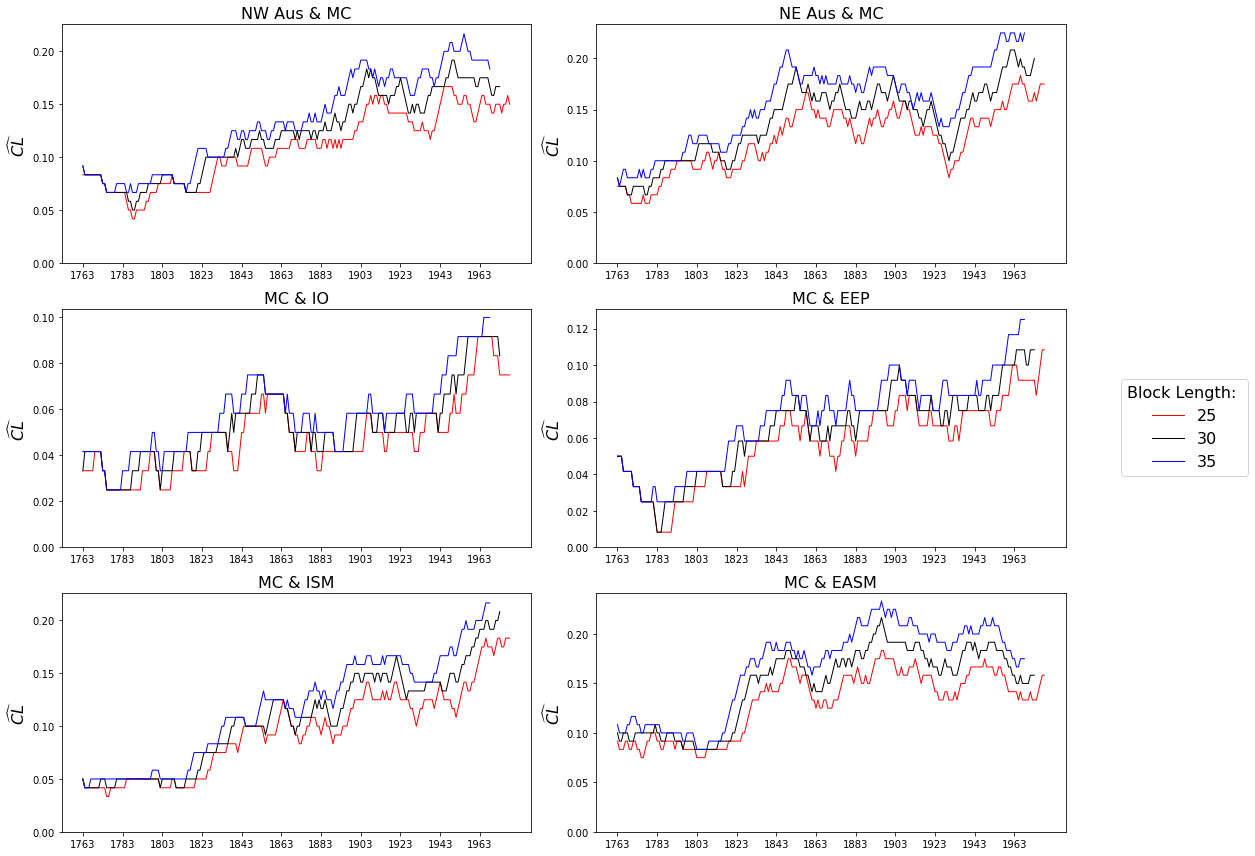

In [354]:
#from matplotlib.patches import Rectangle

colours = ['k','red','blue']
varying_mc = operator.itemgetter(1,6,11,12,13,14)(varying_block_5)
permutation_mc = operator.itemgetter(1,6,11,12,13,14)(permutation_names)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
axs = axs.ravel()
for i in range(len(varying_mc)):
    for j in range(len(varying_mc[i])):
        axs[i].plot(years_5[:-pattern_block_length[j]+1], 
                    varying_mc[i][j],linewidth=1,label=f'{pattern_block_length[j]}' if i==0 else "",
                    c=plot_colours[j])
        axs[i].set_xticks(years_5[:-pattern_block_length[j]+1:20],rotation=0)

    axs[i].set_ylim(bottom=0)#,top=7)
    axs[i].set_title(permutation_mc[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)
    
legend = fig.legend(title='Block Length: ', loc='center',bbox_to_anchor=(1.1,0.5),fontsize=16,title_fontsize=16,fancybox=True)
fig.tight_layout()

# Set Block Length + Events

In [355]:
def regions_temporal(all_ord_pat,window_length,block_length):
    set_block_len = []
    for i,j in tqdm(itertools.combinations(regions,2)):
        vals = temporal_coupling_strength(all_ord_pat[i],all_ord_pat[j],window_length,block_length)
        set_block_len.append(vals)
    return set_block_len

In [356]:
block_len = 30
window_length = 5

set_block_len = regions_temporal(patterns_5,window_length,block_len)

21it [00:00, 136.26it/s]


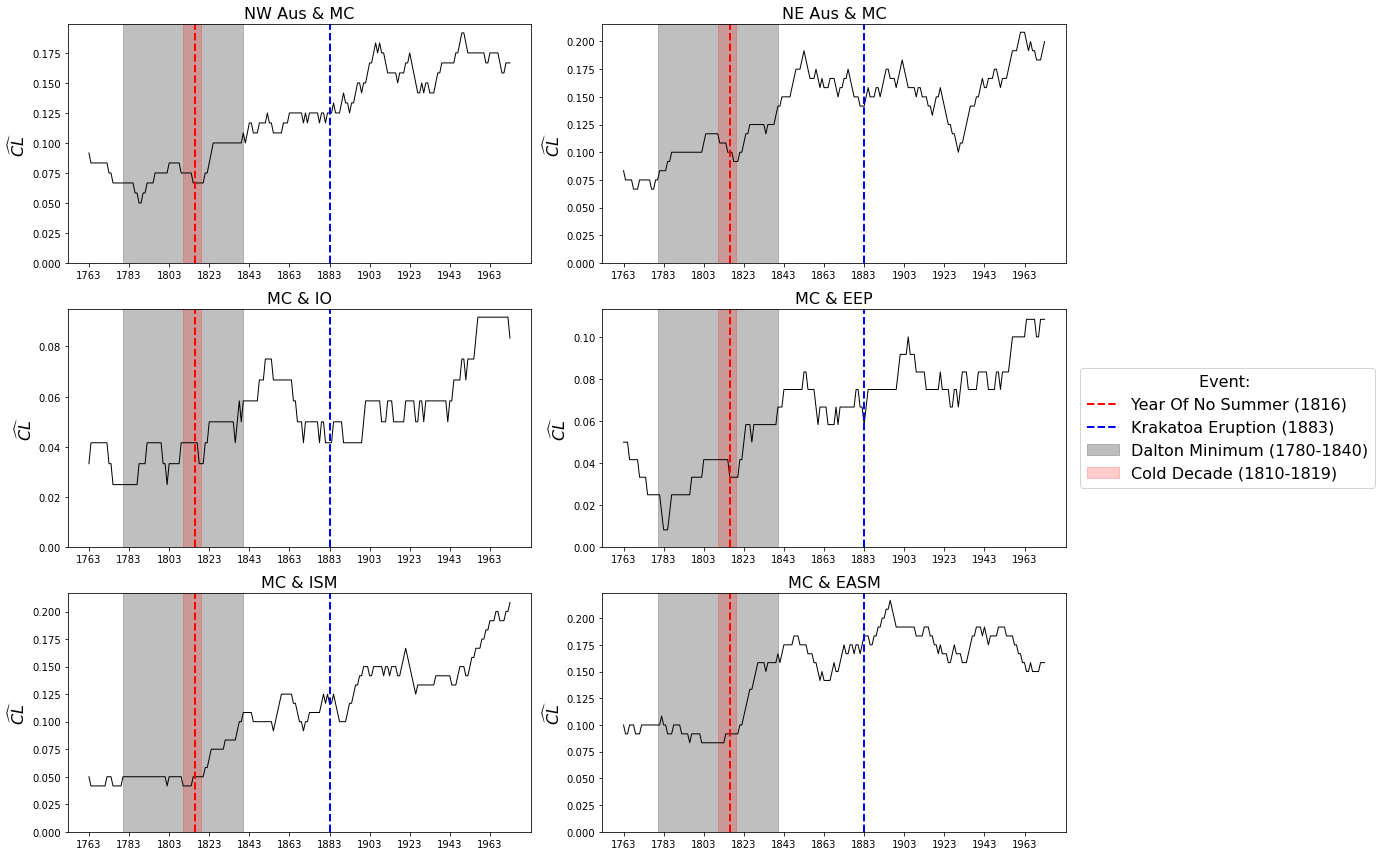

In [357]:
varying_mc = operator.itemgetter(1,6,11,12,13,14)(set_block_len)
permutation_mc = operator.itemgetter(1,6,11,12,13,14)(permutation_names)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
axs = axs.ravel()
for i in range(len(varying_mc)):
    axs[i].plot(years_5[:-block_len+1], varying_mc[i],linewidth=1,c='k')
    axs[i].set_xticks(years_5[:-block_len+1:20],rotation=0)

    axs[i].set_ylim(bottom=0)
    axs[i].set_title(permutation_mc[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)
    
    axs[i].axvline(years_5[53],c='red',linestyle='--',linewidth=2,label='Year Of No Summer (1816)' if i==0 else "")
    axs[i].axvline(years_5[120],c='blue',linestyle='--',linewidth=2,label='Krakatoa Eruption (1883)' if i==0 else "")  
    
    axs[i].fill_between([years_5[17],years_5[77]],[1,1],color='grey',alpha=0.5,label='Dalton Minimum (1780-1840)' if i==0 else "")
    axs[i].fill_between([years_5[47],years_5[56]],[1,1],color='red',alpha=0.2,label='Cold Decade (1810-1819)' if i==1 else "")
legend = fig.legend(title='Event: ', loc='center',bbox_to_anchor=(1.14,0.5),fontsize=16,title_fontsize=16,fancybox=True)

fig.tight_layout()

# Error Bounds

In [75]:
def white_noise_surrogates(original_data):
    '''
    Return a shuffled copy of a time series array.

    Each time series is shuffled individually. The surrogates correspond to
    realizations of white noise consistent with the :attr:`original_data`
    time series' amplitude distribution.
    '''
    
    shuffle = random.shuffle
    surrogate = original_data.copy()
    for i in range(surrogate.shape[0]):
        shuffle(surrogate[i,:])
    return surrogate

In [234]:
def block_surrogate_cl(ord_seq_1,ord_seq_2,window_length,pattern_block_length,n_trials):
    surrogate_cl = np.zeros((len(ord_seq_1) - pattern_block_length + 1,n_trials))
        
    blocks = []
    for i in range(len(ord_seq_1)-pattern_block_length+1):
        lower_bound = i
        upper_bound = i + pattern_block_length
        
        chain_1 = ord_seq_1[lower_bound:upper_bound]
        chain_2 = ord_seq_2[lower_bound:upper_bound]
        
        chains = np.asarray((chain_1,chain_2))
        blocks.append(chains)
        
    for j in tqdm(range(n_trials)):
        for i in range(len(blocks)):
            block = blocks[i]
            surrogate_block = white_noise_surrogates(block)
            
            region_1_surrogate = surrogate_block[0]
            region_2_surrogate = surrogate_block[1]
            
            freqs = count_frequency(co_occur(region_1_surrogate,region_2_surrogate))
            coupling_strength = len(freqs)/math.factorial(window_length)
            surrogate_cl[i][j] = coupling_strength
            
    return surrogate_cl

In [393]:
mc_couplings = [[2,0],[2,1],[2,3],[2,4],[2,5],[2,6]]

n_trials = 10000
block_len = 30
window_length = 5


actual = []
surrogates = []
mc_names = []

for i in range(len(mc_couplings)):
    mc = mc_couplings[i][0]
    other = mc_couplings[i][1]
    
    actual_thing = temporal_coupling_strength(patterns_5[mc],patterns_5[other],window_length,block_len)
    surrogate_thing = block_surrogate_cl(patterns_5[mc],patterns_5[other],window_length,block_len,n_trials)
    
    name_combo = names[mc] + ' & ' + names[other]
    mc_names.append(name_combo)
    
    actual.append(actual_thing)
    surrogates.append(surrogate_thing)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:15<00:00, 31.69it/s]


In [398]:
level_of_sig = 5

surrogate_lower = []
surrogate_upper = []
for i in range(len(surrogates)):
    surrogate_thing = surrogates[i] # Region
    lower_bound = []
    upper_bound = []
    for j in range(len(surrogate_thing)):
        thing = surrogate_thing[j]
        
        lower = np.percentile(thing,level_of_sig/2)
        upper = np.percentile(thing,100-(level_of_sig/2))
        
        lower_bound.append(lower)
        upper_bound.append(upper)
    surrogate_lower.append(lower_bound)
    surrogate_upper.append(upper_bound)

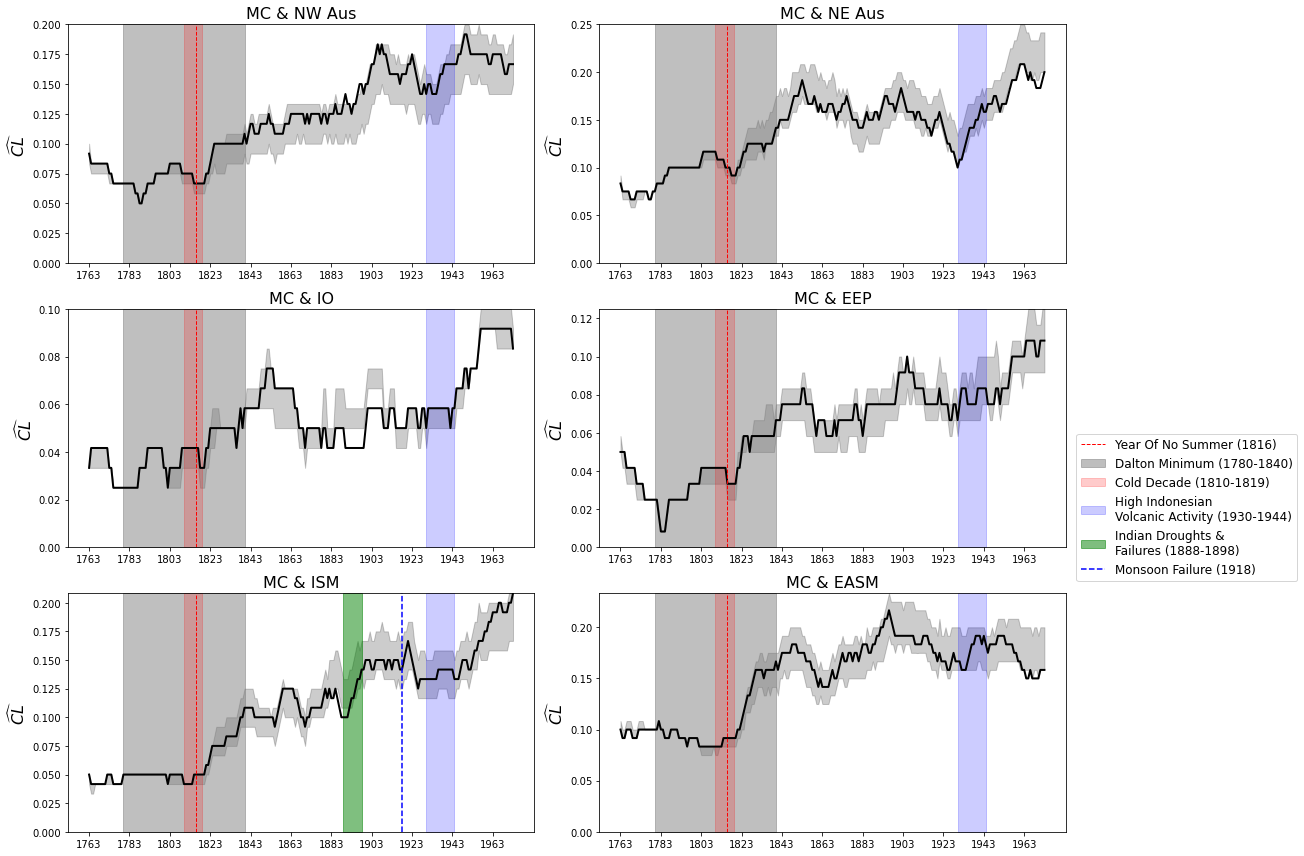

In [447]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
axs = axs.ravel()
for i in range(len(actual)):
    axs[i].plot(years_5[:-30+1], actual[i],linewidth=2,c='k')
    axs[i].set_xticks(years_5[:-30+1:20],rotation=0)

    axs[i].set_ylim(bottom=0,top=max(actual[i]+surrogate_upper[i]))
    axs[i].set_title(mc_names[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)
    
    axs[i].fill_between(years_5[:-30+1],surrogate_lower[i],surrogate_upper[i],color='k',alpha=0.2)
    
    axs[i].axvline(years_5[53],
                   c='red',
                   linestyle='--',
                   linewidth=1,
                   label='Year Of No Summer (1816)' if i==0 else "")
    #axs[i].axvline(years_5[120],
    #               c='orange',
    #               linestyle='--',
    #               linewidth=1,
    #               label='Krakatoa Eruption (1883)' if i==0 else "")
    #axs[i].axvline(years_5[142],
    #               c='k',
    #               linestyle='--',
    #               linewidth=1,
    #               label='Santa Maria Eruption (1903)' if i==0 else "") # Santa Maria, Guatamala
    
    axs[i].fill_between([years_5[17],years_5[77]],
                        [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
                        color='grey',
                        alpha=0.5,
                        label='Dalton Minimum (1780-1840)' if i==0 else "")
    axs[i].fill_between([years_5[47],years_5[56]],
                        [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
                        color='red',
                        alpha=0.2,
                        label='Cold Decade (1810-1819)' if i==1 else "")
    axs[i].fill_between([years_5[167],years_5[181]],
                        [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
                        color='blue',
                        alpha=0.2,
                        label= 'High Indonesian \nVolcanic Activity (1930-1944)' if i==1 else "")
    
    if i == 4:
        axs[i].fill_between([years_5[126],years_5[135]],
                            [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
                            color='green',
                            alpha=0.5,
                            label='Indian Droughts & \nFailures (1888-1898)')
        #axs[i].axvline(years_5[136],c='blue',linestyle='--',label='Monsoon Failure (1899,1918)')
        #axs[i].axvline(years_5[139],c='red',linestyle='--')
        #axs[i].axvline(years_5[142],c='red',linestyle='--')
        axs[i].axvline(years_5[155],c='blue',linestyle='--',label='Monsoon Failure (1918)')
        #axs[i].axvline(years_5[157],c='red',linestyle='--')
    
fig.legend(bbox_to_anchor=(1.21,0.5),fontsize=12)

fig.tight_layout()

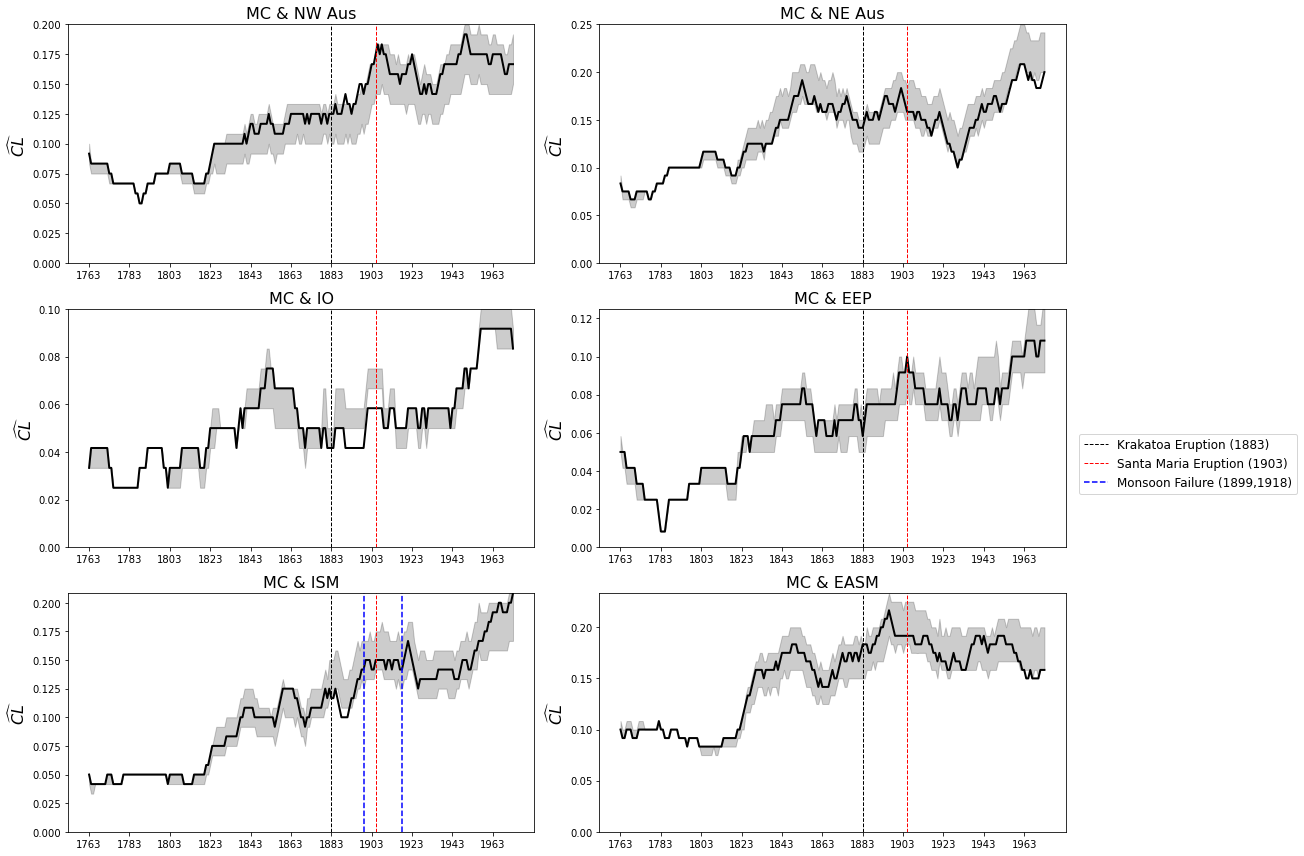

In [449]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15,12))
axs = axs.ravel()
for i in range(len(actual)):
    axs[i].plot(years_5[:-30+1], actual[i],linewidth=2,c='k')
    axs[i].set_xticks(years_5[:-30+1:20],rotation=0)

    axs[i].set_ylim(bottom=0,top=max(actual[i]+surrogate_upper[i]))
    axs[i].set_title(mc_names[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)
    
    axs[i].fill_between(years_5[:-30+1],surrogate_lower[i],surrogate_upper[i],color='k',alpha=0.2)
    
    #axs[i].axvline(years_5[53],
    #               c='red',
    #               linestyle='--',
    #               linewidth=1,
    #               label='Year Of No Summer (1816)' if i==0 else "")
    axs[i].axvline(years_5[120],
                   c='k',
                   linestyle='--',
                   linewidth=1,
                   label='Krakatoa Eruption (1883)' if i==0 else "")
    axs[i].axvline(years_5[142],
                   c='red',
                   linestyle='--',
                   linewidth=1,
                   label='Santa Maria Eruption (1903)' if i==0 else "") # Santa Maria, Guatamala
    
    #axs[i].fill_between([years_5[17],years_5[77]],
    #                    [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
    #                    color='grey',
    #                    alpha=0.5,
    #                    label='Dalton Minimum (1780-1840)' if i==0 else "")
    #axs[i].fill_between([years_5[47],years_5[56]],
    #                    [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
    #                    color='red',
    #                    alpha=0.2,
    #                    label='Cold Decade (1810-1819)' if i==1 else "")
    #axs[i].fill_between([years_5[167],years_5[181]],
    #                    [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
    #                    color='blue',
    #                    alpha=0.2,
    #                    label= 'High Indonesian \nVolcanic Activity (1930-1944)' if i==1 else "")
    
    if i == 4:
        #axs[i].fill_between([years_5[126],years_5[135]],
        #                    [max(actual[i]+surrogate_upper[i]),max(actual[i]+surrogate_upper[i])],
        #                    color='green',
        #                    alpha=0.5,
        #                    label='Indian Droughts & \nFailures (1888-1898)')
        axs[i].axvline(years_5[136],c='blue',linestyle='--',label='Monsoon Failure (1899,1918)')
        #axs[i].axvline(years_5[139],c='red',linestyle='--')
        #axs[i].axvline(years_5[142],c='red',linestyle='--')
        axs[i].axvline(years_5[155],c='blue',linestyle='--')
        #axs[i].axvline(years_5[157],c='red',linestyle='--')
    
fig.legend(bbox_to_anchor=(1.21,0.5),fontsize=12)

fig.tight_layout()

In [358]:
window_length = 5
block_len = 30
n_trials = 100

actual_30_set = regions_temporal(patterns_5,window_length,block_len)

surrogates = []
for i,j in itertools.combinations(regions,2):
    surrogate_dist = block_surrogate_cl(patterns_5[i],patterns_5[j],window_length,block_len,n_trials)
    surrogates.append(surrogate_dist)

21it [00:00, 139.75it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.72it/s]


In [359]:
level_of_sig = 5

surrogate_lower = []
surrogate_upper = []
for i in range(len(surrogates)):
    surrogate_thing = surrogates[i] # Region
    lower_bound = []
    upper_bound = []
    for j in range(len(surrogate_thing)):
        thing = surrogate_thing[j]
        
        lower = np.percentile(thing,level_of_sig/2)
        upper = np.percentile(thing,100-(level_of_sig/2))
        
        lower_bound.append(lower)
        upper_bound.append(upper)
    surrogate_lower.append(lower_bound)
    surrogate_upper.append(upper_bound)

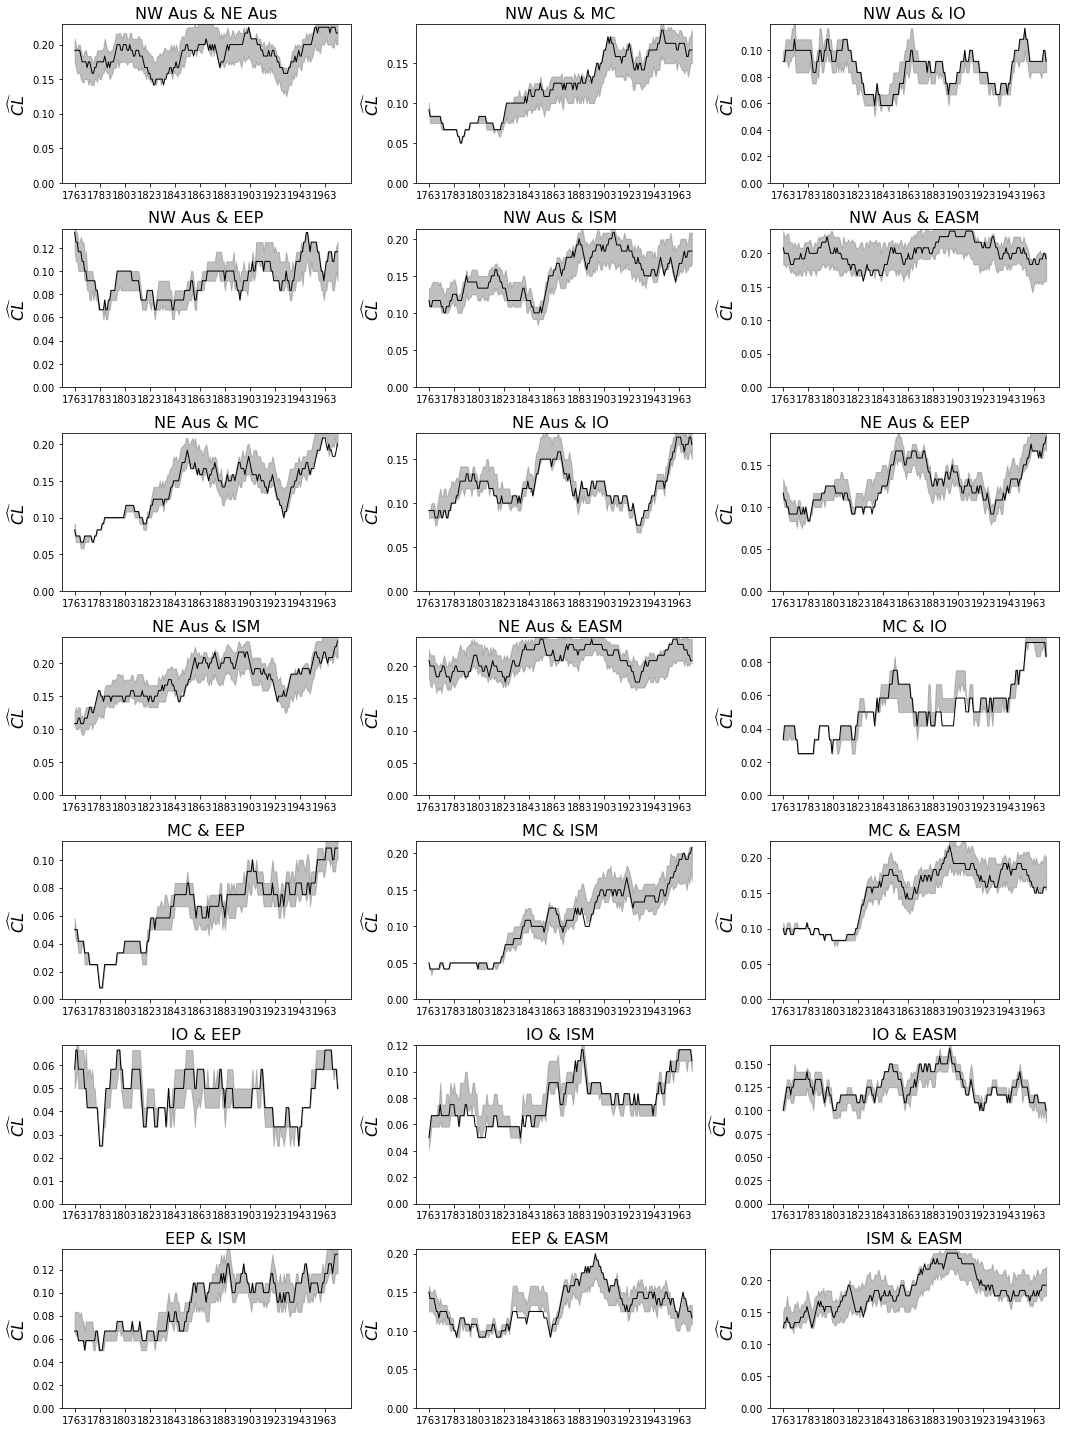

In [363]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15,20))
axs = axs.ravel()
for i in range(len(actual_30_set)):
    axs[i].plot(years_5[:-30+1], actual_30_set[i],linewidth=1,c='k')
    axs[i].set_xticks(years_5[:-30+1:20],rotation=0)

    axs[i].set_ylim(bottom=0)
    axs[i].set_title(permutation_names[i], fontsize=16)
    axs[i].set_ylabel(r'$\widehat{CL}$',  fontsize=16)
    
    axs[i].fill_between(years_5[:-30+1],surrogate_lower[i],surrogate_upper[i],color='grey',alpha=0.5)

fig.tight_layout()